In [1]:
# https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/

# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
import os
import cv2
from random import randint
import numpy as np

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

# To use COLAB
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    #tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False


2022-07-29 12:16:28.152239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 12:16:28.152264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Note: not using Google CoLab


In [2]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    path1 = path + '/A'
    path2 = path + '/B'
    for filename in sorted(listdir(path1)):
        if filename == '.DS_Store':
            pass
        else:
            # load and resize the image
            pixels = load_img(path1 + '/' + filename, color_mode = 'grayscale',target_size=size) # color_mode = 'grayscale'
            # convert to numpy array
            pixels = img_to_array(pixels)
            # split into satellite and map
            sat_img = pixels
            src_list.append(sat_img)
    
    for filename in sorted(listdir(path2)):
        if filename == '.DS_Store':
            pass
        else:
            # load and resize the image
            pixels = load_img(path2 + '/' + filename, target_size=size)
            # convert to numpy array
            pixels = img_to_array(pixels)
            # split into satellite and map
            tar_img = pixels
            tar_list.append(tar_img)
    return [asarray(src_list), asarray(tar_list)]
 
# dataset path
path = 'train'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'immagini_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (80, 256, 256, 1) (80, 256, 256, 3)
Saved dataset:  immagini_256.npz


Loaded:  (80, 256, 256, 1) (80, 256, 256, 3)


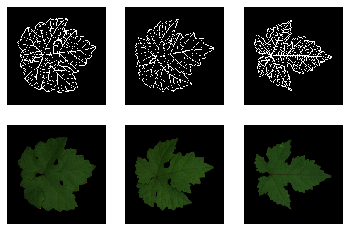

In [4]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('immagini_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8').squeeze(), cmap='gray')
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i]/255)
pyplot.show()

In [3]:
# define the discriminator model
def define_discriminator(image_source_shape, image_target_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_source_shape)
    # target image input
    in_target_image = Input(shape=image_target_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.5)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.5)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


In [4]:
# Defining a U-net encoder-decoder generator model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g
 
# define the standalone generator 256
def define_generator(image_source_shape=(256,256,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_source_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512)#,  dropout=False)
    d5 = decoder_block(d4, e3, 256)#, dropout=False)
    d6 = decoder_block(d5, e2, 128)#, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [6]:
def define_gan(g_model, d_model, image_source_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_source_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [5]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i].squeeze(), cmap = 'gray')
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'Results/plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'Results/model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
    
def train(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)


In [41]:
# load image data
dataset = load_real_samples('immagini_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_source_shape = dataset[0].shape[1:]
image_target_shape = dataset[1].shape[1:]
# define the models
d_model = define_discriminator(image_source_shape, image_target_shape)
g_model = define_generator(image_source_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_source_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (80, 256, 256, 1) (80, 256, 256, 3)
1/1 [==============================] - 0s 449ms/step
>1, d1[0.461] d2[0.693] g[93.997]
1/1 [==============================] - 0s 150ms/step
>2, d1[0.357] d2[0.578] g[96.946]
1/1 [==============================] - 0s 166ms/step
>3, d1[0.397] d2[0.507] g[98.053]
1/1 [==============================] - 0s 148ms/step
>4, d1[0.363] d2[0.504] g[94.725]
1/1 [==============================] - 0s 146ms/step
>5, d1[0.409] d2[0.483] g[86.048]
1/1 [==============================] - 0s 140ms/step
>6, d1[0.332] d2[0.438] g[90.068]
1/1 [==============================] - 0s 155ms/step
>7, d1[0.346] d2[0.421] g[84.697]
1/1 [==============================] - 0s 144ms/step
>8, d1[0.261] d2[0.443] g[85.943]
1/1 [==============================] - 0s 154ms/step
>9, d1[0.259] d2[0.392] g[82.108]
1/1 [==============================] - 0s 158ms/step
>10, d1[0.271] d2[0.325] g[82.555]
1/1 [==============================] - 0s 180ms/step
>11, d1[0.259] d2[0.335] g[76.449

1/1 [==============================] - 0s 177ms/step
>187, d1[0.088] d2[0.365] g[7.116]
1/1 [==============================] - 0s 153ms/step
>188, d1[0.381] d2[0.313] g[5.605]
1/1 [==============================] - 0s 172ms/step
>189, d1[0.619] d2[0.308] g[3.415]
1/1 [==============================] - 0s 160ms/step
>190, d1[0.597] d2[0.312] g[3.710]
1/1 [==============================] - 0s 183ms/step
>191, d1[0.540] d2[0.364] g[4.191]
1/1 [==============================] - 0s 181ms/step
>192, d1[0.511] d2[0.384] g[3.218]
1/1 [==============================] - 0s 195ms/step
>193, d1[0.104] d2[0.376] g[7.171]
1/1 [==============================] - 0s 187ms/step
>194, d1[0.519] d2[0.339] g[4.074]
1/1 [==============================] - 0s 210ms/step
>195, d1[0.485] d2[0.450] g[2.807]
1/1 [==============================] - 0s 226ms/step
>196, d1[0.384] d2[0.467] g[3.842]
1/1 [==============================] - 0s 177ms/step
>197, d1[0.277] d2[0.364] g[6.956]
1/1 [===========================

KeyboardInterrupt: 

Loaded (80, 256, 256, 1) (80, 256, 256, 3)


2022-07-29 12:16:41.235559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alessandro/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-29 12:16:41.235582: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 12:16:41.235602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Parula): /proc/driver/nvidia/version does not exist
2022-07-29 12:16:41.236008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 12:16:41.540715: W

1/1 [==============================] - 1s 525ms/step


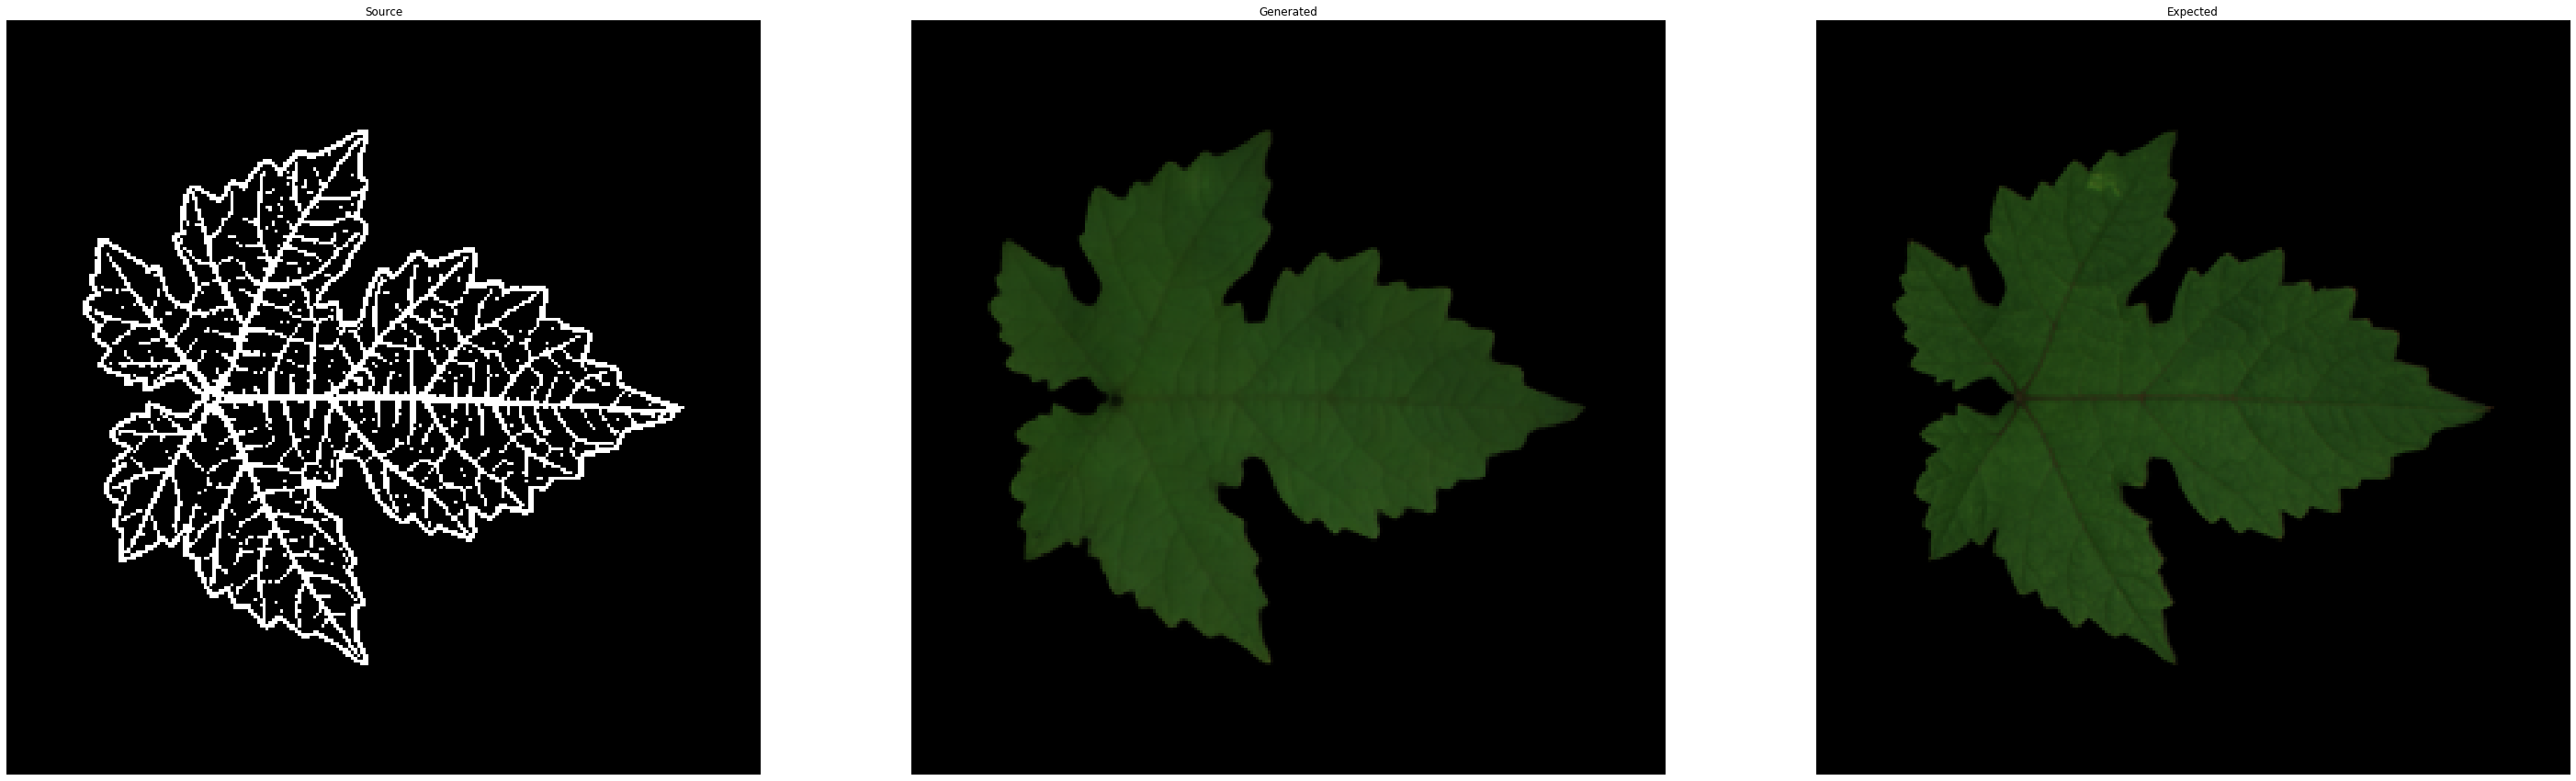

In [6]:
# example of loading a pix2pix model and using it for image to image translation
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from numpy.random import randint
from matplotlib import pyplot
 
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays      
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    # scale from [-1,1] to [0,1]
    src_img = (src_img + 1)/2.0
    gen_img = (gen_img + 1) / 2.0
    tar_img = (tar_img + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # define subplot
    fig, axs = plt.subplots(1,3,figsize=(50,50))
    # plot raw pixel data
    axs[0].imshow(src_img.squeeze(), cmap='gray')
    axs[0].axis('off')
    # show title
    axs[0].title.set_text(titles[0])

    pyplot.subplot(1, 3, 2)
    pyplot.axis('off')
    pyplot.imshow(gen_img[0])
    pyplot.title(titles[1])

    pyplot.subplot(1, 3, 3)
    pyplot.axis('off')
    pyplot.imshow(tar_img[0])
    pyplot.title(titles[2])

    # save plot to file
    pyplot.show()
    
# load dataset
[X1, X2] = load_real_samples('immagini_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('Results/model_012000.h5')
# select random example
ix = randint(0, len(X1), 1)
ix = [2]
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (1, 256, 256, 1)
1/1 [==============================] - 1s 508ms/step

The model does not have ever seen this veins pattern.


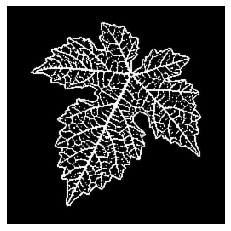

This is the generated leaf, using as base the veins pattern.


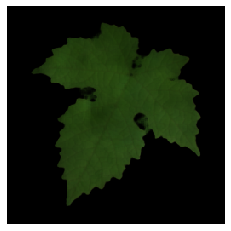

In [9]:
# example of loading a pix2pix model and using it for one-off image translation
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot

from scipy import ndimage
 
# load an image
def load_image(filename, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(filename, color_mode = 'grayscale' ,target_size=size)

    pixels = ndimage.rotate(pixels, 45, reshape = False)

    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels
 
# load source image
src_image = load_image('Skeleton_outside_train.png')
print('Loaded', src_image.shape)
# load model
model = load_model('Results/model_012000.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0

print('')
print('The model does not have ever seen this veins pattern.')
pyplot.imshow(src_image.squeeze(), cmap= 'gray')
pyplot.axis('off')
pyplot.show()
print('This is the generated leaf, using as base the veins pattern.')
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()